PREPROCESSING

In [3]:
'''Imports'''
import json
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy
from tqdm import tqdm
import warnings
import os
from rapidfuzz import process, fuzz

In [3]:
'''Reading Data'''
data_dir_comments = r"C:\Users\gungo\OneDrive\Desktop\stocks_comments.ndjson"
data_dir_sub = r"C:\Users\gungo\OneDrive\Desktop\stocks_submissions.ndjson"
df_com = pd.read_json(data_dir_comments, lines=True)
df_sub = pd.read_json(data_dir_sub, lines=True)

In [4]:
'''Reducing Data'''
df_com_reduced = df_com[['created_utc','score','body']]
df_sub_reduced = df_sub[['created_utc','score','selftext']]

df_com_reduced = df_com_reduced.rename(columns={'body': 'text'})
df_sub_reduced = df_sub_reduced.rename(columns={'selftext': 'text'})

df_merged = pd.concat([df_com_reduced, df_sub_reduced], ignore_index=True)

In [21]:
'''Pre-Processing'''
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    """Cleans, tokenizes, removes stopwords, and stems text."""
    if not isinstance(text, str):
        return ""
    #text = text.lower()       Not needed for NER. Actually makes it worse
    text = re.sub(r'&amp;#x200B;', '', text)
    text = re.sub('&amp;', '', text) # remove some special characters from the data &amp; corresponds to &
    text = re.sub(r'\s+', ' ', text)  # eliminate duplicate whitespaces using regex
    #text = re.sub(r'\[[^]]*\]', '', text)  # remove text in square brackets
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'\binc\b', '', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    #text = ' '.join(stemmer.stem(word) for word in text.split() if word not in stop_words)
    return text

def preprocess(df):
    """Preprocesses the 'body' or 'selftext' column and removes '[removed]' entries."""
    
    text_col = 'text'

    # Remove NaN and '[removed]' rows
    df = df[df[text_col].notna()]
    df = df[~df[text_col].str.contains(r'\[removed\]', na=False)]
    df = df[~df[text_col].str.contains(r'\[deleted\]', na=False)]

    # Apply text preprocessing
    df['processed_text'] = df[text_col].apply(preprocess_text)

    return df.reset_index(drop=True)

pre_processed_df = preprocess(df_merged)

In [23]:
'''Display'''
pre_processed_df.head(20)

,created_utc,score,text,processed_text
0,1654041658,-1,Musk is a clown. He knew 50% of his followers ...,Musk clown. He knew 50% followers bots. He kne...
1,1654041696,100,What's the cumulative short loss? $50 billion ...,What's cumulative short loss? $50 billion coun...
2,1654041706,2,"Quantum computing is physics, but physics isn'...","Quantum computing physics, physics business. A..."
3,1654041743,62,MANGA,MANGA
4,1654041839,8,AMD?\n\nThey sell on the merits of their produ...,"AMD? They sell merits products, open source so..."
5,1654041840,12,Highly coincidental that this drastic drop in ...,Highly coincidental drastic drop price happene...
6,1654041851,2,"Of course you can time the market, on a macro ...","Of course time market, macro basis - follow Th..."
7,1654041856,1,However the issue is with the decay. It may s...,However issue decay. It may show 100% gains hi...
8,1654041865,13,They exclude the 5% they know about.\n\nAnd it...,They exclude 5% know about. And matter. Advert...
9,1654041907,11,The board dgaf what Dorsey days.,The board dgaf Dorsey days.


NAMED ENTITY RECOGNITION

In [24]:
top100_path = r'Top_100.csv'
Top_100 = pd.read_csv(top100_path)

Top_100.columns = [col.strip().lower() for col in Top_100.columns]

# Create dictionaries for fast lookups
ticker_to_name = dict(zip(Top_100['symbol'].str.upper(), Top_100['name']))
valid_tickers = set(ticker_to_name.keys())
company_names = [name.lower() for name in ticker_to_name.values()]
name_to_ticker = {name.lower(): symbol for symbol, name in ticker_to_name.items()}

In [25]:
#model
nlp = spacy.load('en_core_web_sm')

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

#to be ran per comment
def extract_ner_entities(model, text, similarity_threshold=90):
    
    BLACKLIST = {'ev', 'covid', 'etf', 'nyse', 'sec', 'spac', 'fda', 'treasury', 'covid-19', 'rrsp', 'tfsa','fed'}
    doc = model(text)
    detected_companies = []

    #Detect companies via spaCy NER
    for ent in doc.ents:
        if ent.label_ == "ORG" and ent.text.lower() not in BLACKLIST:
            org_name = ent.text.strip()
            # Fuzzy match against official company names from csv file
            match, score, _ = process.extractOne(org_name.lower(), company_names, scorer=fuzz.token_sort_ratio)
            if score >= similarity_threshold:
                matched_ticker = name_to_ticker[match]
                canonical_name = ticker_to_name[matched_ticker]
                detected_companies.append(canonical_name)
            else:
                #keeps companies not in csv file maybe delete later
                detected_companies.append(org_name)

    # --- Match stock tickers in text ---
    for token in doc:
        token_text = token.text.strip()

        # Handle tickers with $ prefix, e.g. $AAPL
        if token_text.startswith("$"):
            token_text = token_text[1:]

        # Check if it’s a valid ticker symbol
        if token_text in valid_tickers:
            company_name = ticker_to_name.get(token_text)
            detected_companies.append(company_name)


    return list(set(detected_companies))


def get_dict_top_companies(dataset, column_name, top_companies=10):
    company_counter = dict()
    for companies in dataset[column_name]:
        for company in companies:
            if company in company_counter:  
                company_counter[company] += 1
            else:
                company_counter[company] = 1
    sorted_dict = dict(sorted(company_counter.items(), key=lambda x: x[1], reverse=True))
    top = dict()
    for company, count in list(sorted_dict.items())[:top_companies]:
        top[company] = count

    return top


In [26]:
# Ensure every cell is a string (NaN -> "")
pre_processed_df['processed_text'] = pre_processed_df['processed_text'].fillna("").astype(str)

# Safe wrapper so extract_ner_entities always receives a string
def safe_extract(text):
    if not text or not isinstance(text, str):
        return []
    return extract_ner_entities(nlp, text, similarity_threshold=60)

pre_processed_df["Companies"] = pre_processed_df['processed_text'].apply(safe_extract)

In [29]:
top_dict = get_dict_top_companies(pre_processed_df, "Companies", 3)
top_set = set(top_dict.keys())
print(f"Top companies: {top_dict}")

masked = pre_processed_df['Companies'].apply(lambda lst: bool(top_set.intersection(lst)))
filtered_df = pre_processed_df[masked].copy()

exploded_sub = filtered_df.explode('Companies')

# Keep only rows for top companies 
exploded_sub = exploded_sub[exploded_sub['Companies'].isin(top_set)].copy()

# Create separate dataframes for each top company 
dfs_by_company = {}
os.makedirs("companies_csv", exist_ok=True)

for company in top_set:
    dfs_by_company[company] = exploded_sub[exploded_sub['Companies'] == company].copy()
    file_path = os.path.join("companies_csv", f"{company}_company_data.csv")
    dfs_by_company[company].to_csv(file_path, index=False)
    print(f"{company}: {len(dfs_by_company[company])} rows saved to {file_path}")

print("\nPreview of each company's dataframe:\n")
for company, df_company in dfs_by_company.items():
    print(f"=== {company.upper()} ({len(df_company)} rows) ===")
    display(df_company.head(3))   
    print("\n")

filtered_df.to_csv("filtered_top_companies.csv", index=False)  #not really needed, just the dataframe with all top companies submissions
print("Saved filtered_top_companies.csv")


Top companies: {'Apple': 9784, 'Tesla': 8876, 'Amazon': 6926}
Amazon: 6926 rows saved to companies_csv\Amazon_company_data.csv
Tesla: 8876 rows saved to companies_csv\Tesla_company_data.csv
Apple: 9784 rows saved to companies_csv\Apple_company_data.csv

Preview of each company's dataframe:

=== AMAZON (6926 rows) ===


,created_utc,score,text,processed_text,Companies
106,1654044916,3,Split was announced march 9. Price was about $...,Split announced march 9. Price $2800. I would ...,Amazon
108,1654044952,4,"Best time to grab Amazon for example, in more ...","Best time grab Amazon example, recent times, d...",Amazon
125,1654045467,4,I’ve bought Amazon the last week or so while i...,I’ve bought Amazon last week gonna keep adding...,Amazon




=== TESLA (8876 rows) ===


,created_utc,score,text,processed_text,Companies
1,1654041696,100,What's the cumulative short loss? $50 billion ...,What's cumulative short loss? $50 billion coun...,Tesla
19,1654042100,9,He seems to already have a liquidated billions...,He seems already liquidated billions Tesla sha...,Tesla
70,1654043939,-3,https://www.theverge.com/2022/5/10/23065061/te...,Tesla won’t beat Q2 earning estimates. May Elo...,Tesla




=== APPLE (9784 rows) ===


,created_utc,score,text,processed_text,Companies
4,1654041839,8,AMD?\n\nThey sell on the merits of their produ...,"AMD? They sell merits products, open source so...",Apple
223,1654048857,31,The thing that keeps me bullish on AAPL's sust...,The thing keeps bullish AAPL's sustained growt...,Apple
235,1654049132,11,AAPL is on sale right now,AAPL sale right,Apple




Saved filtered_top_companies.csv


## FinBERT Sentiment Analysis



#### Import Packages


In [8]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timezone
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"    # avoid TF backend import
os.environ["TRANSFORMERS_NO_FLAX"] = "1"  # avoid Flax


c:\Users\gungo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



#### FinBERT Model Setup


In [9]:

MODEL = "ProsusAI/finbert"

# Only install the model on CPU if it isn't yet
if "model" not in globals():
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)
    DEVICE = "cpu"
    model.to(DEVICE).eval()
    print(f"Loaded FinBERT on {DEVICE}.")
else:
    new_device = "cpu"
    if str(next(model.parameters()).device) != new_device:
        model.to(new_device).eval()
        DEVICE = new_device
        print(f"Moved model to {DEVICE}.")
    else:
        print(f"Model already loaded to {str(next(model.parameters()).device)}; skipping.")

id2label = model.config.id2label  
# id2abel --> {0:'positive',1:'negative',2:'neutral'}


c:\Users\gungo\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\gungo\.cache\huggingface\hub\models--ProsusAI--finbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to 

Loaded FinBERT on cpu.


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`



#### Function Definitions


In [ ]:

def finbert_proba(texts, batch_size=32, device=DEVICE, max_length=256):
    """
    Return a list of dicts of probabilities: [{'negative': p, 'neutral': p, 'positive': p}, ...]
    """
    all_probs = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            enc = tokenizer(
                batch,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=max_length
            ).to(device)
            logits = model(**enc).logits
            probs = F.softmax(logits, dim=-1).cpu().tolist()
            for p in probs:
                # map indices -> labels dict
                out = {id2label[j]: float(p[j]) for j in range(len(p))}
                # ensure all three keys exist
                for k in ("negative", "neutral", "positive"):
                    out.setdefault(k, 0.0)
                all_probs.append(out)
    return all_probs

def top2_margin(p: dict) -> float:
    """
    Return max_prob - second_prob in [0,1].
    """
    vals = sorted([p["negative"], p["neutral"], p["positive"]], reverse=True)
    return float(vals[0] - vals[1])

def sentiment_score(texts):
    """
    Return continuous score per text in [-1,1]: (p(pos) - p(neg)). 
    Appliy damping based on neutrality and top 2 margin
    """
    probs = finbert_proba(texts)
    scores = []
    for p in probs:
        base = (p["positive"] - p["negative"])           
        neutral_damp = (1.0 - p["neutral"])             
        margin_damp = top2_margin(p)                           
        scores.append(base * neutral_damp * margin_damp)
    return scores

# tanh with 30D window
def tanh_scale_series(scores, timestamps=None, percentile=95, min_periods=14):
    """
    30D rolling P95 tanh scaling.
    Returns
      w: np.ndarray in [-1, 1] (tanh-scaled, sign preserved)
      k_used: np.ndarray of per-row k values (rolling P95 of |score|)
    """
    s = np.asarray(scores, dtype=float)
    if s.size == 0:
        return s.astype(float), np.array([], dtype=float)
    s = np.nan_to_num(s, nan=0.0)

    if timestamps is not None:
        ts = pd.to_datetime(pd.Series(timestamps), utc=True, errors="coerce")
        abs_s = pd.Series(np.abs(s), index=ts).sort_index()
        roll_p = abs_s.rolling("30D", min_periods=min_periods).quantile(percentile/100.0)
        g_p = abs_s.quantile(percentile/100.0) if len(abs_s) else 1.0
        k_series = roll_p.fillna(g_p).clip(lower=1.0)
        # align per-row k back to original order (by timestamps)
        k_used = k_series.reindex(ts).to_numpy()
        # fallback for NaT rows
        k_used = np.where(np.isfinite(k_used), k_used, max(g_p, 1.0))
    else:
        # global P95
        g_p = np.percentile(np.abs(s), percentile) if s.size else 1.0
        k_used = np.full_like(s, fill_value=max(g_p, 1.0), dtype=float)

    w = np.tanh(s / k_used)
    return w.astype(float), k_used.astype(float)

def score_multiplier(raw_sentiment_scores, reddit_scores, percentile=95):
    """
    returns: list of crowd-adjusted scores in [-1, 1]
    """
    rs = np.asarray(raw_sentiment_scores, dtype=float)
    w, k_used = tanh_scale_series(reddit_scores, percentile=percentile)
    # elementwise combine to not multiply by raw reddit_scores again
    return (rs * w).tolist(), k_used



#### Running the Model on Data


Data definition

In [11]:

# proper, multiple datasets lines below
file_locations ={"Amazon" : r"companies_csv\Amazon_company_data.csv", 
                 "Apple" : r"companies_csv\Apple_company_data.csv", 
                 "Tesla" : r"companies_csv\Tesla_company_data.csv"} 


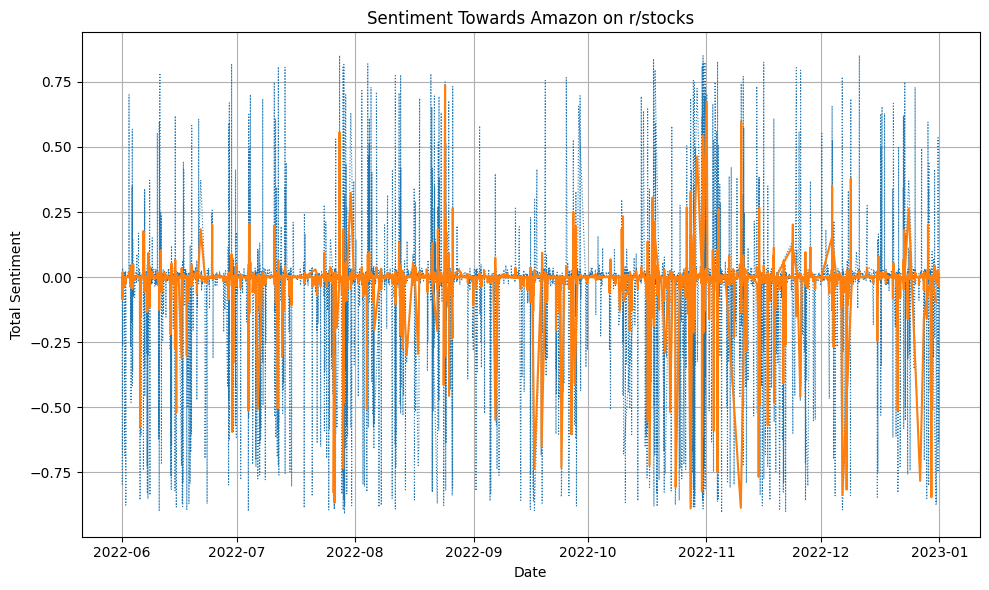

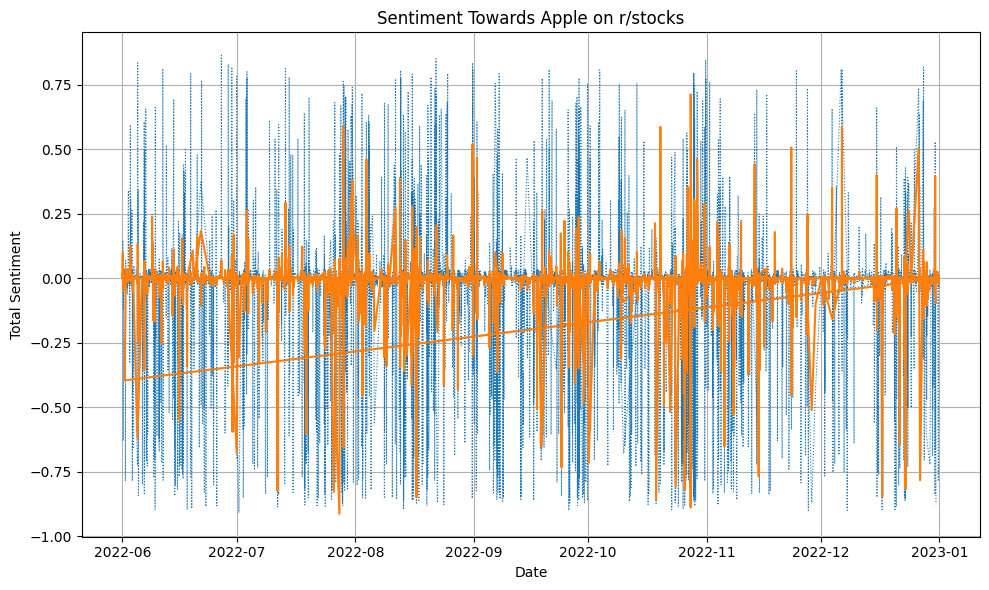

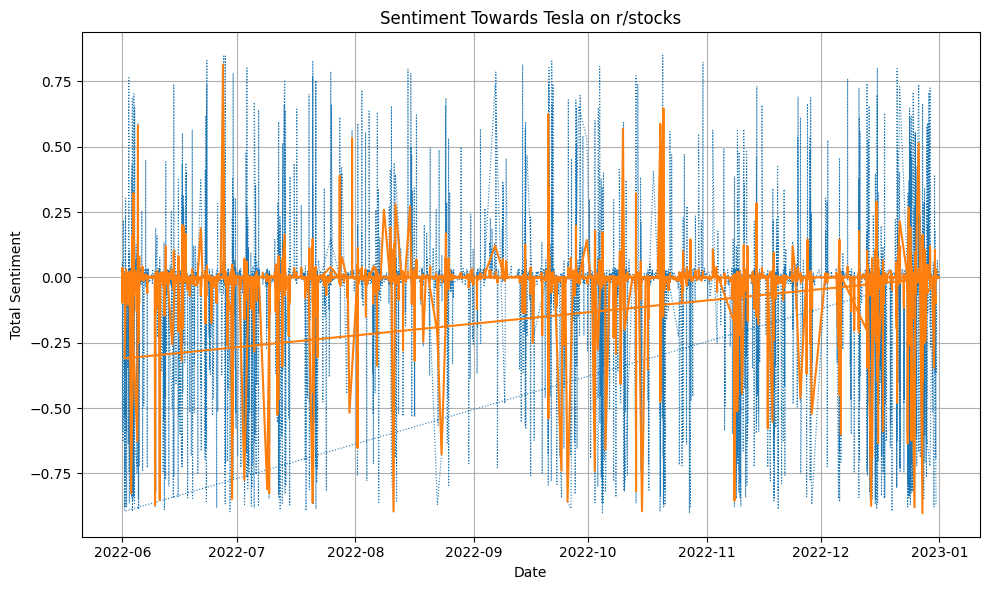

In [ ]:

# singular test line below
# file_locations = {"Amazon" : r"C:\Users\ftomi\Desktop\NLP project\Amazon_submissions.csv"}

#using dfs_by_company -> {"Amazon" : df_amazon}

for fl in file_locations:
#for company, df_company in dfs_by_company.items():

    df = pd.read_csv(file_locations[fl])

    dates = []
    texts = []
    upvotes = [] 
    scaled_sentiment_scores = []
    raw_sentiment_scores = []

    data = df.to_dict('index')
    for i in range(len(data)):
        texts.append(data[i]['processed_text'].lower())
        dates.append(datetime.fromtimestamp(data[i]['created_utc'], tz=timezone.utc))
        upvotes.append(data[i]['score'])

    probs = finbert_proba(texts)
    raw_sentiment_scores = sentiment_score(texts)
    scaled_sentiment_scores, k_used = score_multiplier(sentiment_score(texts), upvotes)
    
    # save as dataframe
    sentiment_df = pd.DataFrame(dict(scaled_sentiment = scaled_sentiment_scores, created_utc = dates))
    sentiment_df.to_csv(f"{fl}_sentiment_data.csv", index=False)

    #show and save figure
    plt.figure(figsize=(10,6))
    plt.plot(dates, raw_sentiment_scores, label = "raw",  linestyle=":", linewidth=0.8)
    plt.plot(dates, scaled_sentiment_scores, label = "scaled by reddit score")
    plt.title(f"Sentiment Towards {fl} on r/stocks")
    plt.xlabel("Date")
    plt.ylabel("Total Sentiment")
    plt.tight_layout()
    plt.grid()
    plt.savefig(f"{fl}_plot.png", dpi=300, bbox_inches="tight")
    plt.show()

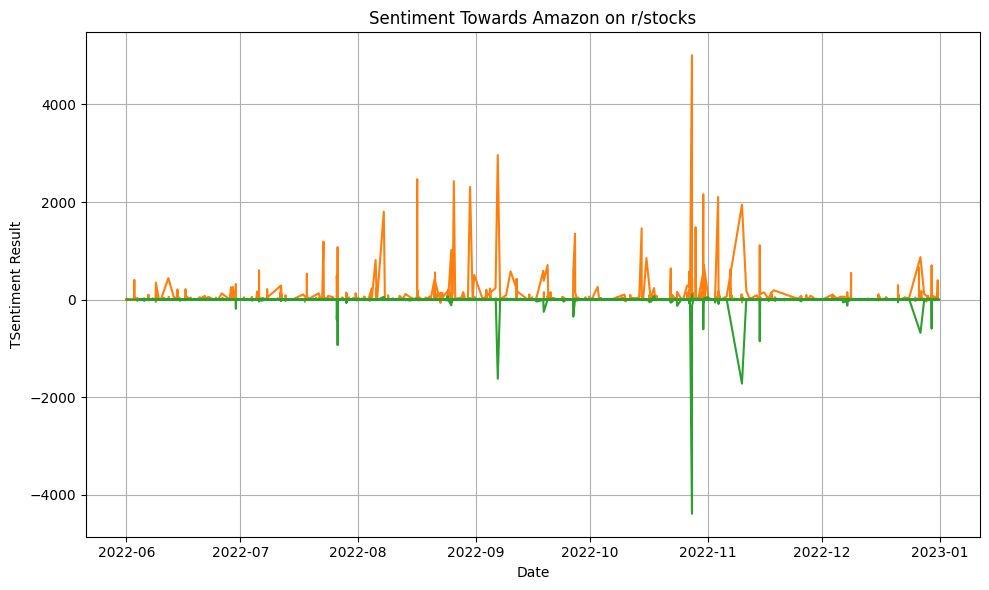

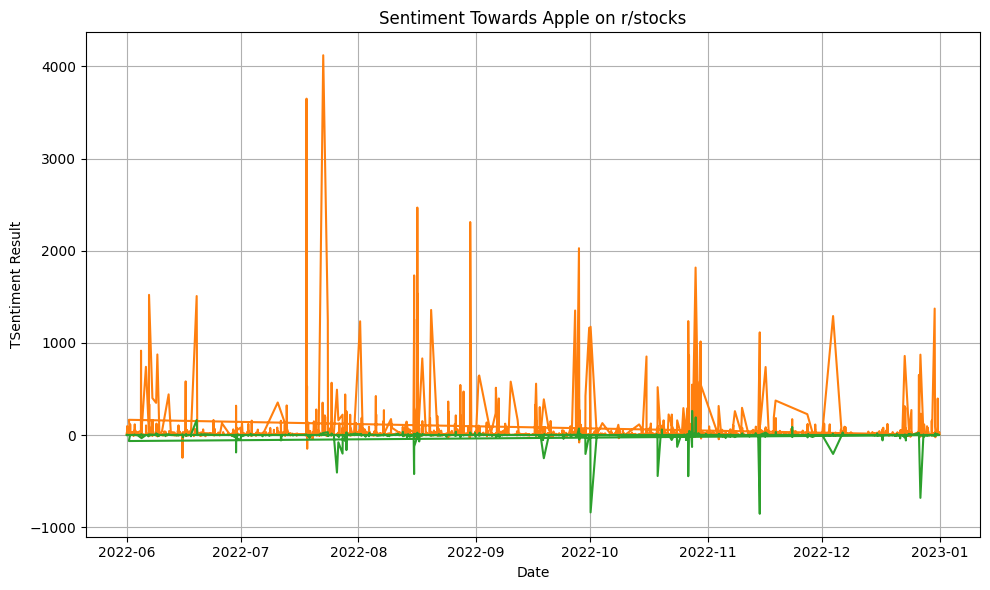

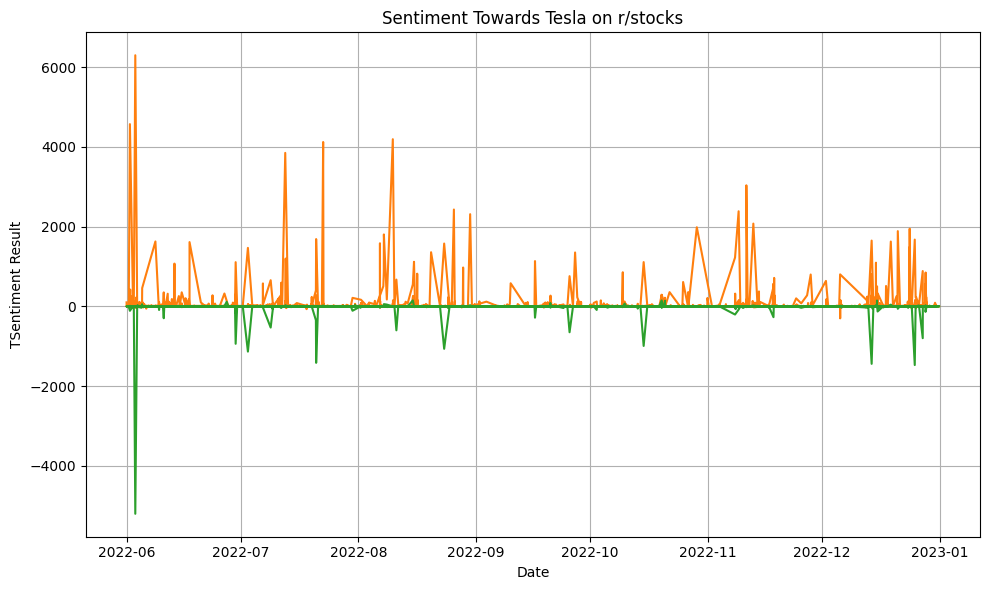

In [ ]:
def sentiment_result(raw_sentiment_scores, reddit_scores):
    return np.array(raw_sentiment_scores) * np.array(reddit_scores)

for fl in file_locations:

    df = pd.read_csv(file_locations[fl])

    texts = []
    dates = []
    scores = []
    raw_sentiments = []
    sentiment_results = []
    

    data = df.to_dict('index')
    for i in range(len(data)):
        texts.append(data[i]['processed_text'].lower())
        dates.append(datetime.fromtimestamp(data[i]['created_utc'], tz=timezone.utc))
        scores.append(data[i]['score'])
        
    raw_sentiments = sentiment_score(texts)
    sentiment_results = sentiment_result(raw_sentiments, scores)
    
    # save as dataframe
    sentiment_df = pd.DataFrame(dict(date=dates, reddit_score=scores, raw_sentiment=raw_sentiments, result=sentiment_results))
    sentiment_df.to_csv(f"{fl}_emre_sentiment_result.csv", index=False)

    #show and save figure
    plt.figure(figsize=(10,6))
    plt.plot(dates, raw_sentiments, label = "raw sentiment",  linestyle=":", linewidth=0.8)
    plt.plot(dates, scores, label = "reddit scores")
    plt.plot(dates, sentiment_results, label = "result")
    plt.title(f"Sentiment Towards {fl} on r/stocks")
    plt.xlabel("Date")
    plt.ylabel("TSentiment Result")
    plt.tight_layout()
    plt.grid()
    plt.savefig(f"{fl}_emre_plot.png", dpi=300, bbox_inches="tight")
    plt.show()

## Model Evaluation



#### Sample Selection


In [10]:

import random
random.seed(42) 

p = 0.002           

samples = []

for name, path in file_locations.items():   # dict: key=name, value=path
    df = pd.read_csv(path, skiprows=lambda i: (i > 0) and (random.random() > p))
    df["__source"] = name  # so we can see contributions
    print(f"{name} -> kept {len(df):,} rows from {os.path.basename(path)}")
    samples.append(df)

combined = pd.concat(samples, ignore_index=True)
print("\nPer-file rows kept:")
print(combined["__source"].value_counts())

combined.to_csv("FinBERT_TEST_SET.csv", index=False)
print("Wrote: FinBERT_TEST_SET.csv | rows:", len(combined))


Amazon -> kept 14 rows from Amazon_company_data.csv
Apple -> kept 20 rows from Apple_company_data.csv
Tesla -> kept 20 rows from Tesla_company_data.csv

Per-file rows kept:
__source
Apple     20
Tesla     20
Amazon    14
Name: count, dtype: int64
Wrote: FinBERT_TEST_SET.csv | rows: 54



#### Test


In [33]:

# Using the file 'test_sample_annotated.csv' which is a redacted, human-annotated version of 'FinBERT_TEST_SET.csv'.
test_sample_annotated = pd.read_csv(r"test_sample_annotated.csv")

def finbert_evaluation(df):
    text_og = df["text"].astype(str).str.lower().tolist()
    text_pp = df["processed_text"].astype(str).str.lower().tolist()
    probs_og = finbert_proba(text_og, device=DEVICE)
    probs_pp = finbert_proba(text_pp, device=DEVICE)
    argmax_og = [max(p.items(), key=lambda kv: kv[1]) for p in probs_og]
    argmax_pp = [max(p.items(), key=lambda kv: kv[1]) for p in probs_pp]
    df["selftext_finbert_label"] = [k for k, v in argmax_og]
    df["selftext_finbert_score"] = [v for k, v in argmax_og]
    df["processed_finbert_label"] = [k for k, v in argmax_pp]
    df["processed_finbert_score"] = [v for k, v in argmax_pp]
    return df

# outputs in SAME folder as inputs
test_complete = finbert_evaluation(test_sample_annotated)
test_complete.to_csv("test_sample_complete.csv", index=False)

# helper funcs 
def find_gold_col(df):
    for name in ["gold_score"]:
        if name in df.columns: 
            return name
    raise KeyError("Could not find the golden-standard column.")

def add_human_label(df):
    df = df.copy()
    gcol = find_gold_col(df)
    scores = pd.to_numeric(df[gcol], errors="coerce")
    mapping = {1: "positive", 0: "neutral", -1: "negative"}
    df["human_label"] = scores.map(mapping)
    return df

def eval_preds(df, pred_cols):
    """Return accuracy + confusion matrices for each predicted label column."""
    out = {}
    y_true = df["human_label"].str.lower()
    mask = y_true.notna()
    for col in pred_cols:
        y_pred = df[col].astype(str).str.lower()
        acc = float((y_pred[mask] == y_true[mask]).mean())
        cm = pd.crosstab(y_true[mask], y_pred[mask], dropna=False).reindex(
            index=["negative","neutral","positive"], columns=["negative","neutral","positive"], fill_value=0
        )
        out[col] = {"accuracy": acc, "confusion": cm}
    return out

def print_report(name, results):
    print(f"\n=== {name} ===")
    for col, r in results.items():
        print(f"\n{col}  —  accuracy: {r['accuracy']:.3f}")
        print(r["confusion"])

# add human-labels
comments = add_human_label(test_sample_annotated)

# evaluate vs FinBERT labels (adjust column names if yours differ)
comment_results = eval_preds(
    comments, pred_cols=["selftext_finbert_label", "processed_finbert_label"]
)

print_report("COMMENTS", comment_results)


=== COMMENTS ===

selftext_finbert_label  —  accuracy: 0.538
selftext_finbert_label  negative  neutral  positive
human_label                                        
negative                       0        3         1
neutral                        3       13         0
positive                       0        5         1

processed_finbert_label  —  accuracy: 0.500
processed_finbert_label  negative  neutral  positive
human_label                                         
negative                        0        3         1
neutral                         3       13         0
positive                        1        5         0


## Sentiment-Stock Correlation

In [16]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


#CONFIG
START_noNAN = "2022-05-30"   # start a day early to avoid first-return NaN
START     = "2022-06-01"
END       = "2022-12-31"
LAGS      = range(-3, 4)   # -3 to +3

# Each df must have columns: created_utc, scaled_sentiment
'''Connect with FinBERT df's'''
sentiment_daily_by_company = {
    "AMZN": pd.read_csv('Amazon_sentiment_data.csv'),   
    "AAPL": pd.read_csv('Apple_sentiment_data.csv'),   
    "TSLA": pd.read_csv('Tesla_sentiment_data.csv') 
}

In [17]:
def get_stock_returns(ticker, start=START_noNAN, end=END):

    data = yf.download(ticker, start=start, end=end)
    # Flatten possible MultiIndex columns
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = ['_'.join(c).strip() if isinstance(c, tuple) else c for c in data.columns]

    # Find the "Close" column 
    close_col = [c for c in data.columns if 'Close' in c and not 'Adj' in c][0]

    # Daily returns and slice actual window
    data['daily_return'] = data[close_col].pct_change()
    data = data.loc[START:END]

    # Make index tz-naive
    data.index = pd.to_datetime(data.index).tz_localize(None)
    
    return data[['daily_return']]

In [18]:
def prep_sentiment_daily(df):
    """Takes a per-company sentiment df with columns created_utc, scaled_sentiment and returns daily mean for every day in range."""
    sr = df.copy()
    # Parse datetime (tz-aware), then drop tz to align with yfinance

    sr['date'] = pd.to_datetime(sr['created_utc'], utc=True, errors='coerce').dt.tz_localize(None)

    # Force numeric and clip to [-1,1]
    sr['scaled_sentiment'] = pd.to_numeric(sr['scaled_sentiment'], errors='coerce').clip(-1, 1)
    
    # Group to daily means
    daily = (sr
             .set_index('date')
             .groupby(pd.Grouper(freq='D'))['scaled_sentiment']
             .mean()
             .to_frame('mean_sentiment')
             .loc[START:END])
    
    return daily

In [19]:
def analyze_company(ticker, sent_df):
    print(f"\n=== {ticker} ===")
    
    returns = get_stock_returns(ticker, start=START_noNAN, end=END)
    sentiment_daily = prep_sentiment_daily(sent_df)

    # Build correlation-ready dataset (drop missing on either side)
    combined_corr = (returns
                     .join(sentiment_daily, how='inner')
                     .dropna(subset=['daily_return', 'mean_sentiment']))

    stock_days     = len(returns.dropna(subset=['daily_return']))
    sentiment_days = len(sentiment_daily.dropna(subset=['mean_sentiment']))
    analyzed_days  = len(combined_corr)
    print(f"Trading days in window: {stock_days}")
    print(f"Days with sentiment: {sentiment_days}")
    print(f"Days analyzed: {analyzed_days}")


    # Lag test 
    print("\nLag correlation (mean_sentiment shifted by lag):")
    for lag in LAGS:
        p = combined_corr['daily_return'].corr(combined_corr['mean_sentiment'].shift(lag), method='pearson')
        s = combined_corr['daily_return'].corr(combined_corr['mean_sentiment'].shift(lag), method='spearman')
        direction = ("sentiment follows price" if lag < 0 else "same day" if lag == 0 else "sentiment leads price")
        print(f"Lag {lag:+} days ({direction:23s}) | Pearson: {p: .3f} | Spearman: {s: .3f}")

    # Plotting dataset (plot for all trading days, interpolate for days missing sentiment)
    sentiment_plot = sentiment_daily.copy()
    sentiment_plot['mean_sentiment'] = sentiment_plot['mean_sentiment'].interpolate(limit_direction='both')

    combined_plot = returns.join(sentiment_plot, how='left')

    # Normalize for plotting
    scaler = MinMaxScaler(feature_range=(-1, 1))
    combined_plot['return_norm']    = scaler.fit_transform(combined_plot[['daily_return']])
    combined_plot['sentiment_norm'] = scaler.fit_transform(combined_plot[['mean_sentiment']])

    plt.figure(figsize=(12, 6))
    plt.plot(combined_plot.index, combined_plot['return_norm'],    label=f'{ticker} Daily Return (normalized)', linewidth=2)
    plt.plot(combined_plot.index, combined_plot['sentiment_norm'], label=f'{ticker} Sentiment (normalized, interpolated)', linewidth=2, alpha=0.85)
    plt.title(f'{ticker}: Sentiment vs Daily Returns ({START} to {END})', fontsize=14)
    plt.xlabel('Date'); plt.ylabel('Normalized scale (-1 to 1)')
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout()
    plt.show()

#### Results

C:\Users\gungo\AppData\Local\Temp\ipykernel_44000\749615040.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


=== AMZN ===
Trading days in window: 148
Days with sentiment: 213
Days analyzed: 147

Lag correlation (mean_sentiment shifted by lag):
Lag -3 days (sentiment follows price) | Pearson:  0.112 | Spearman:  0.103
Lag -2 days (sentiment follows price) | Pearson:  0.009 | Spearman:  0.082
Lag -1 days (sentiment follows price) | Pearson:  0.006 | Spearman:  0.056
Lag +0 days (same day               ) | Pearson:  0.089 | Spearman:  0.161
Lag +1 days (sentiment leads price  ) | Pearson: -0.212 | Spearman: -0.151
Lag +2 days (sentiment leads price  ) | Pearson: -0.079 | Spearman: -0.145
Lag +3 days (sentiment leads price  ) | Pearson:  0.003 | Spearman:  0.002


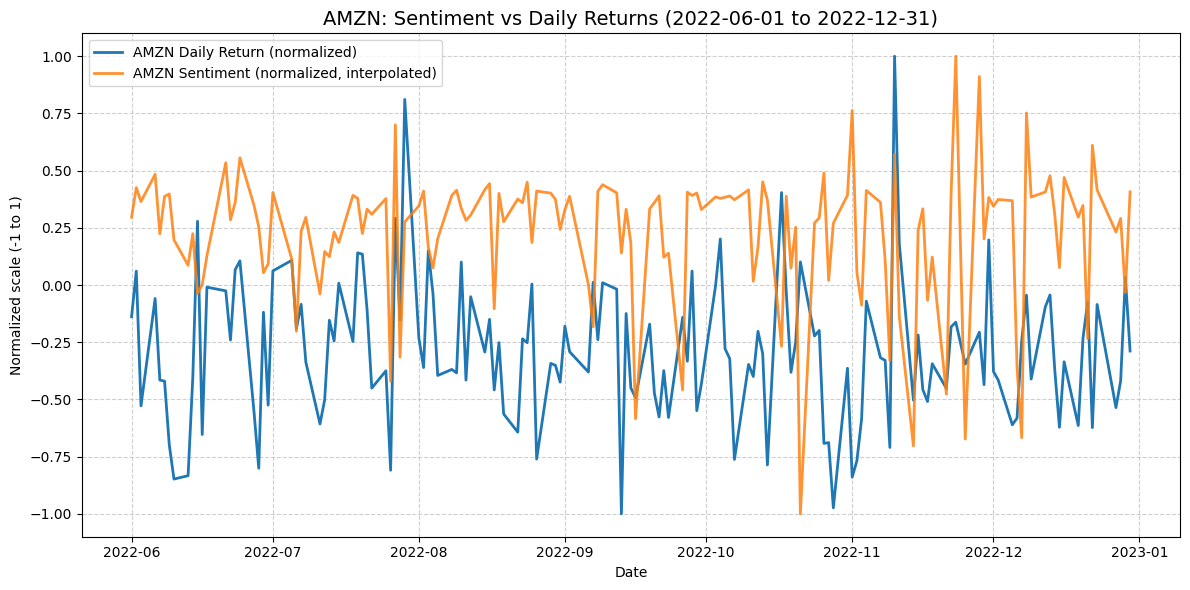

C:\Users\gungo\AppData\Local\Temp\ipykernel_44000\749615040.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


=== AAPL ===
Trading days in window: 148
Days with sentiment: 214
Days analyzed: 148

Lag correlation (mean_sentiment shifted by lag):
Lag -3 days (sentiment follows price) | Pearson: -0.054 | Spearman: -0.087
Lag -2 days (sentiment follows price) | Pearson: -0.051 | Spearman: -0.071
Lag -1 days (sentiment follows price) | Pearson: -0.062 | Spearman: -0.014
Lag +0 days (same day               ) | Pearson:  0.044 | Spearman:  0.067
Lag +1 days (sentiment leads price  ) | Pearson: -0.007 | Spearman: -0.092
Lag +2 days (sentiment leads price  ) | Pearson: -0.215 | Spearman: -0.118
Lag +3 days (sentiment leads price  ) | Pearson: -0.202 | Spearman: -0.190


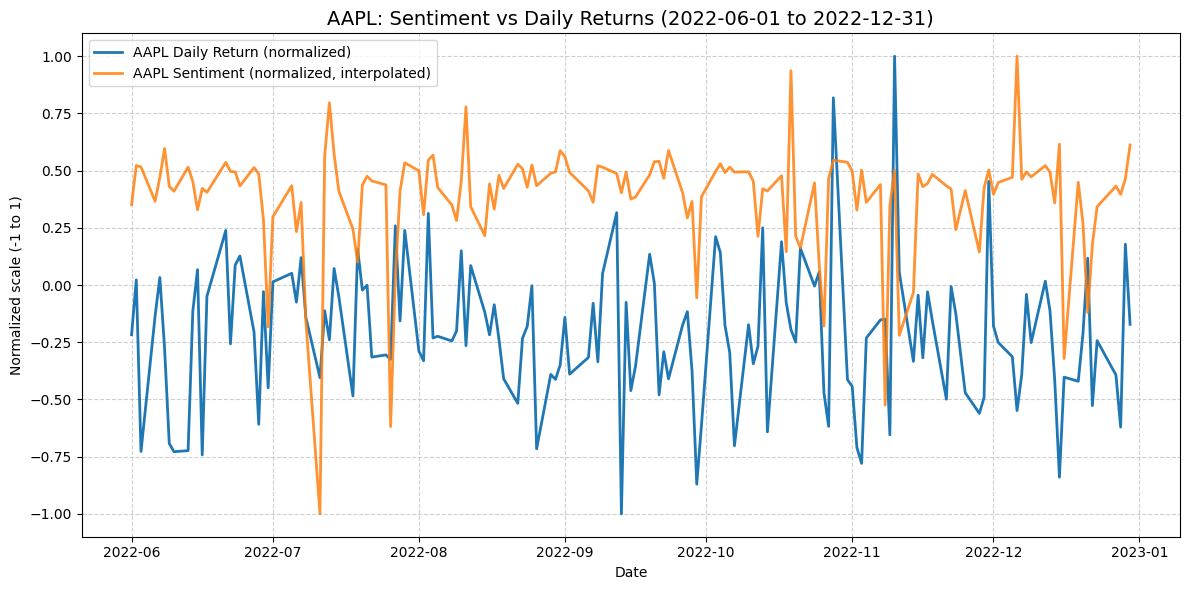

C:\Users\gungo\AppData\Local\Temp\ipykernel_44000\749615040.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


=== TSLA ===
Trading days in window: 148
Days with sentiment: 214
Days analyzed: 148

Lag correlation (mean_sentiment shifted by lag):
Lag -3 days (sentiment follows price) | Pearson:  0.110 | Spearman:  0.099
Lag -2 days (sentiment follows price) | Pearson:  0.063 | Spearman:  0.100
Lag -1 days (sentiment follows price) | Pearson: -0.079 | Spearman: -0.021
Lag +0 days (same day               ) | Pearson:  0.163 | Spearman:  0.252
Lag +1 days (sentiment leads price  ) | Pearson:  0.033 | Spearman:  0.048
Lag +2 days (sentiment leads price  ) | Pearson:  0.053 | Spearman:  0.008
Lag +3 days (sentiment leads price  ) | Pearson: -0.224 | Spearman: -0.212


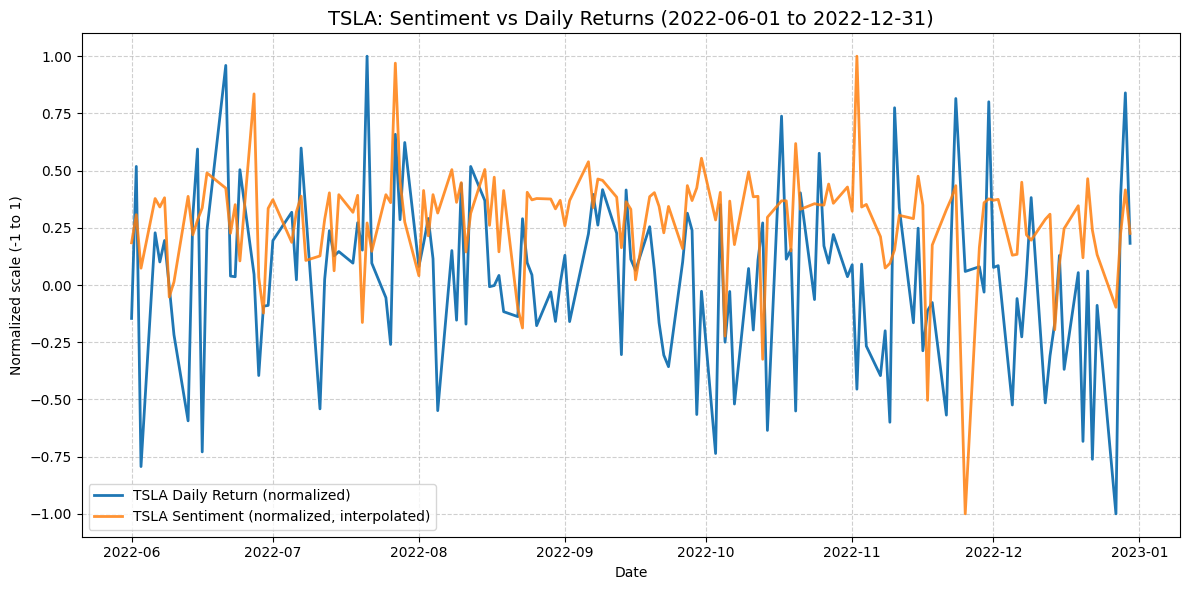

,scaled_sentiment,created_utc
0,-0.000123,2022-06-01 00:55:16+00:00
1,-0.085610,2022-06-01 00:55:52+00:00
2,0.000303,2022-06-01 01:04:27+00:00
3,-0.000164,2022-06-01 01:22:42+00:00
4,-0.001737,2022-06-01 01:34:57+00:00
5,-0.000284,2022-06-01 01:41:21+00:00
6,-0.000000,2022-06-01 01:52:05+00:00
7,0.000506,2022-06-01 02:14:51+00:00
8,0.001559,2022-06-01 02:46:48+00:00
9,0.018961,2022-06-01 02:49:33+00:00


In [21]:
for ticker, sent_df in sentiment_daily_by_company.items():
    analyze_company(ticker, sent_df)
sentiment_daily_by_company["AMZN"].head(20)